In [33]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
import json

console = Console()

In [34]:
research_agent_prompt =  """You are a research assistant conducting research on the user's input topic. For context, today's date is {date}.

<Task>
Your job is to use tools to gather information about the user's input topic.
You can use any of the tools provided to you to find resources that can help answer the research question. You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.
</Task>

<Available Tools>
You have access to two main tools:
1. **tavily_search**: For conducting web searches to gather information
2. **think_tool**: For reflection and strategic planning during research

**CRITICAL: Use think_tool after each search to reflect on results and plan next steps**
</Available Tools>

<Instructions>
Think like a human researcher with limited time. Follow these steps:

1. **Read the question carefully** - What specific information does the user need?
2. **Start with broader searches** - Use broad, comprehensive queries first
3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?
4. **Execute narrower searches as you gather information** - Fill in the gaps
5. **Stop when you can answer confidently** - Don't keep searching for perfection
</Instructions>

<Hard Limits>
**Tool Call Budgets** (Prevent excessive searching):
- **Simple queries**: Use 2-3 search tool calls maximum
- **Complex queries**: Use up to 5 search tool calls maximum
- **Always stop**: After 5 search tool calls if you cannot find the right sources

**Stop Immediately When**:
- You can answer the user's question comprehensively
- You have 3+ relevant examples/sources for the question
- Your last 2 searches returned similar information
</Hard Limits>

<Show Your Thinking>
After each search tool call, use think_tool to analyze the results:
- What key information did I find?
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?
</Show Your Thinking>
"""

compress_research_system_prompt = """You are a research assistant that has conducted research on a topic by calling several tools and web searches. Your job is now to clean up the findings, but preserve all of the relevant statements and information that the researcher has gathered. For context, today's date is {date}.

<Task>
You need to clean up information gathered from tool calls and web searches in the existing messages.
All relevant information should be repeated and rewritten verbatim, but in a cleaner format.
The purpose of this step is just to remove any obviously irrelevant or duplicate information.
For example, if three sources all say "X", you could say "These three sources all stated X".
Only these fully comprehensive cleaned findings are going to be returned to the user, so it's crucial that you don't lose any information from the raw messages.
</Task>

<Tool Call Filtering>
**IMPORTANT**: When processing the research messages, focus only on substantive research content:
- **Include**: All tavily_search results and findings from web searches
- **Exclude**: think_tool calls and responses - these are internal agent reflections for decision-making and should not be included in the final research report
- **Focus on**: Actual information gathered from external sources, not the agent's internal reasoning process

The think_tool calls contain strategic reflections and decision-making notes that are internal to the research process but do not contain factual information that should be preserved in the final report.
</Tool Call Filtering>

<Guidelines>
1. Your output findings should be fully comprehensive and include ALL of the information and sources that the researcher has gathered from tool calls and web searches. It is expected that you repeat key information verbatim.
2. This report can be as long as necessary to return ALL of the information that the researcher has gathered.
3. In your report, you should return inline citations for each source that the researcher found.
4. You should include a "Sources" section at the end of the report that lists all of the sources the researcher found with corresponding citations, cited against statements in the report.
5. Make sure to include ALL of the sources that the researcher gathered in the report, and how they were used to answer the question!
6. It's really important not to lose any sources. A later LLM will be used to merge this report with others, so having all of the sources is critical.
</Guidelines>

<Output Format>
The report should be structured like this:
**List of Queries and Tool Calls Made**
**Fully Comprehensive Findings**
**List of All Relevant Sources (with citations in the report)**
</Output Format>

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
</Citation Rules>

Critical Reminder: It is extremely important that any information that is even remotely relevant to the user's research topic is preserved verbatim (e.g. don't rewrite it, don't summarize it, don't paraphrase it).
"""
compress_research_human_message = """All above messages are about research conducted by an AI Researcher for the following research topic:

RESEARCH TOPIC: {research_topic}

Your task is to clean up these research findings while preserving ALL information that is relevant to answering this specific research question. 

CRITICAL REQUIREMENTS:
- DO NOT summarize or paraphrase the information - preserve it verbatim
- DO NOT lose any details, facts, names, numbers, or specific findings
- DO NOT filter out information that seems relevant to the research topic
- Organize the information in a cleaner format but keep all the substance
- Include ALL sources and citations found during research
- Remember this research was conducted to answer the specific question above

The cleaned findings will be used for final report generation, so comprehensiveness is critical."""

final_report_generation_prompt = """Based on all the research conducted, create a comprehensive, well-structured answer to the overall research brief:
<Research Brief>
{research_brief}
</Research Brief>

CRITICAL: Make sure the answer is written in the same language as the human messages!
For example, if the user's messages are in English, then MAKE SURE you write your response in English. If the user's messages are in Chinese, then MAKE SURE you write your entire response in Chinese.
This is critical. The user will only understand the answer if it is written in the same language as their input message.

Today's date is {date}.

Here are the findings from the research that you conducted:
<Findings>
{findings}
</Findings>

Please create a detailed answer to the overall research brief that:
1. Is well-organized with proper headings (# for title, ## for sections, ### for subsections)
2. Includes specific facts and insights from the research
3. References relevant sources using [Title](URL) format
4. Provides a balanced, thorough analysis. Be as comprehensive as possible, and include all information that is relevant to the overall research question. People are using you for deep research and will expect detailed, comprehensive answers.
5. Includes a "Sources" section at the end with all referenced links

You can structure your report in a number of different ways. Here are some examples:

To answer a question that asks you to compare two things, you might structure your report like this:
1/ intro
2/ overview of topic A
3/ overview of topic B
4/ comparison between A and B
5/ conclusion

To answer a question that asks you to return a list of things, you might only need a single section which is the entire list.
1/ list of things or table of things
Or, you could choose to make each item in the list a separate section in the report. When asked for lists, you don't need an introduction or conclusion.
1/ item 1
2/ item 2
3/ item 3

To answer a question that asks you to summarize a topic, give a report, or give an overview, you might structure your report like this:
1/ overview of topic
2/ concept 1
3/ concept 2
4/ concept 3
5/ conclusion

If you think you can answer the question with a single section, you can do that too!
1/ answer

REMEMBER: Section is a VERY fluid and loose concept. You can structure your report however you think is best, including in ways that are not listed above!
Make sure that your sections are cohesive, and make sense for the reader.

For each section of the report, do the following:
- Use simple, clear language
- Use ## for section title (Markdown format) for each section of the report
- Do NOT ever refer to yourself as the writer of the report. This should be a professional report without any self-referential language. 
- Do not say what you are doing in the report. Just write the report without any commentary from yourself.
- Each section should be as long as necessary to deeply answer the question with the information you have gathered. It is expected that sections will be fairly long and verbose. You are writing a deep research report, and users will expect a thorough answer.
- Use bullet points to list out information when appropriate, but by default, write in paragraph form.

REMEMBER:
The brief and research may be in English, but you need to translate this information to the right language when writing the final answer.
Make sure the final answer report is in the SAME language as the human messages in the message history.

Format the report in clear markdown with proper structure and include source references where appropriate.

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Each source should be a separate line item in a list, so that in markdown it is rendered as a list.
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
- Citations are extremely important. Make sure to include these, and pay a lot of attention to getting these right. Users will often use these citations to look into more information.
</Citation Rules>
"""


In [35]:

def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """
    Display a prompt with rich formatting and XML tag highlighting.
    
    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")  # Highlight headers
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(Panel(
        formatted_text, 
        title=f"[bold green]{title}[/bold green]",
        border_style=border_style,
        padding=(1, 2)
    ))

In [36]:
show_prompt(research_agent_prompt, title="Research Agent Prompt")

╭───────────────────────────────────────────── Research Agent Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

In [37]:

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ===== STATE DEFINITIONS =====

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.
    
    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.
    
    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

In [38]:
summarize_webpage_prompt = """You are tasked with summarizing the raw content of a webpage retrieved from a web search. Your goal is to create a summary that preserves the most important information from the original web page. This summary will be used by a downstream research agent, so it's crucial to maintain the key details without losing essential information.

Here is the raw content of the webpage:

<webpage_content>
{webpage_content}
</webpage_content>

Please follow these guidelines to create your summary:

1. Identify and preserve the main topic or purpose of the webpage.
2. Retain key facts, statistics, and data points that are central to the content's message.
3. Keep important quotes from credible sources or experts.
4. Maintain the chronological order of events if the content is time-sensitive or historical.
5. Preserve any lists or step-by-step instructions if present.
6. Include relevant dates, names, and locations that are crucial to understanding the content.
7. Summarize lengthy explanations while keeping the core message intact.

When handling different types of content:

- For news articles: Focus on the who, what, when, where, why, and how.
- For scientific content: Preserve methodology, results, and conclusions.
- For opinion pieces: Maintain the main arguments and supporting points.
- For product pages: Keep key features, specifications, and unique selling points.

Your summary should be significantly shorter than the original content but comprehensive enough to stand alone as a source of information. Aim for about 25-30 percent of the original length, unless the content is already concise.

Present your summary in the following format:

```
{{
   "summary": "Your summary here, structured with appropriate paragraphs or bullet points as needed",
   "key_excerpts": "First important quote or excerpt, Second important quote or excerpt, Third important quote or excerpt, ...Add more excerpts as needed, up to a maximum of 5"
}}
```

Here are two examples of good summaries:

Example 1 (for a news article):
```json
{{
   "summary": "On July 15, 2023, NASA successfully launched the Artemis II mission from Kennedy Space Center. This marks the first crewed mission to the Moon since Apollo 17 in 1972. The four-person crew, led by Commander Jane Smith, will orbit the Moon for 10 days before returning to Earth. This mission is a crucial step in NASA's plans to establish a permanent human presence on the Moon by 2030.",
   "key_excerpts": "Artemis II represents a new era in space exploration, said NASA Administrator John Doe. The mission will test critical systems for future long-duration stays on the Moon, explained Lead Engineer Sarah Johnson. We're not just going back to the Moon, we're going forward to the Moon, Commander Jane Smith stated during the pre-launch press conference."
}}
```

Example 2 (for a scientific article):
```json
{{
   "summary": "A new study published in Nature Climate Change reveals that global sea levels are rising faster than previously thought. Researchers analyzed satellite data from 1993 to 2022 and found that the rate of sea-level rise has accelerated by 0.08 mm/year² over the past three decades. This acceleration is primarily attributed to melting ice sheets in Greenland and Antarctica. The study projects that if current trends continue, global sea levels could rise by up to 2 meters by 2100, posing significant risks to coastal communities worldwide.",
   "key_excerpts": "Our findings indicate a clear acceleration in sea-level rise, which has significant implications for coastal planning and adaptation strategies, lead author Dr. Emily Brown stated. The rate of ice sheet melt in Greenland and Antarctica has tripled since the 1990s, the study reports. Without immediate and substantial reductions in greenhouse gas emissions, we are looking at potentially catastrophic sea-level rise by the end of this century, warned co-author Professor Michael Green."  
}}
```

Remember, your goal is to create a summary that can be easily understood and utilized by a downstream research agent while preserving the most critical information from the original webpage.

Today's date is {date}.
"""

In [39]:
import os
import platform
import subprocess
from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient



def get_today_str() -> str:
    """Get current date in a human-readable format (cross-platform, same behavior)."""
    fmt = "%a %b %-d, %Y" if platform.system() != "Windows" else "%a %b %#d, %Y"
    return datetime.now().strftime(fmt)

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

def convert_path_for_mcp(path: Path) -> str:
    """Convert a path to Windows format for MCP servers on WSL.
    
    On WSL, MCP servers need to run with Windows Node.js which requires
    Windows-style paths. This function converts WSL paths to Windows format.
    
    Args:
        path: Path object to convert
        
    Returns:
        String path in Windows format on WSL, unchanged otherwise
    """
    path_str = str(path)
    
    # Check if we're on WSL - convert to Windows format
    if platform.system() == "Linux" and "microsoft" in platform.release().lower():
        try:
            # Use wslpath to convert WSL path to Windows format
            result = subprocess.run(
                ["wslpath", "-w", path_str],
                capture_output=True,
                text=True,
                check=True
            )
            return result.stdout.strip()
        except Exception:
            # If conversion fails, return original path
            return path_str
    
    # Not on WSL, return path as-is
    return path_str

# ===== CONFIGURATION =====

# Primary: Google Gemini | Alternatives: "openai:gpt-4.1-mini", "anthropic:claude-haiku-3-5-20241022"
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("GOOGLE_GENAI_API_KEY")
summarization_model = init_chat_model(model="gemini-2.5-pro", model_provider="google_genai", temperature=0.0)

tavily_client = TavilyClient(api_key="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")

# ===== SEARCH FUNCTIONS =====

def tavily_search_multiple(
    search_queries: List[str], 
    max_results: int = 3, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """
    
    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )
        
        return formatted_summary
        
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results: List of search result dictionaries
        
    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}
    
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        unique_results: Dictionary of unique search results
        
    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}
    
    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])
        
        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.
    
    Args:
        summarized_results: Dictionary of processed search results
        
    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"
    
    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

# ===== RESEARCH TOOLS =====

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # Execute search for single query
    search_results = tavily_search_multiple(
        [query],  # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results with summarization
    summarized_results = process_search_results(unique_results)

    # Format output for consumption
    return format_search_output(summarized_results)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"





In [40]:
from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model


# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models - Primary: Google Gemini | Alternatives: OpenAI, Anthropic
model = init_chat_model(model="gemini-2.5-pro", model_provider="google_genai", temperature=0.0)  # Alternatives: "openai:gpt-4.1", "anthropic:claude-sonnet-4-20250514"
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model="gemini-2.5-pro", model_provider="google_genai", temperature=0.0)  # Alternatives: "openai:gpt-4.1-mini", "anthropic:claude-haiku-3-5-20241022"
compress_model = init_chat_model(model="gemini-2.5-pro", model_provider="google_genai", temperature=0.0, max_tokens=32000)  # Alternatives: "openai:gpt-4.1", "anthropic:claude-sonnet-4-20250514"

# ===== AGENT NODES =====

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)
    
    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()

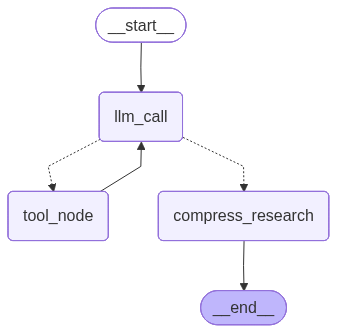

In [42]:
from IPython.display import Image, display

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [46]:


def format_message_content(message):
    """Convert message content to displayable string"""
    parts = []
    tool_calls_processed = False
    
    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))
    
    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")
            parts.append(f"   ID: {tool_call['id']}")
    
    return "\n".join(parts)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting"""
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)

        if msg_type == 'Human':
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))

def format_message(messages):
    """Alias for format_messages for backward compatibility"""
    return format_messages(messages)





In [47]:
from langchain_core.messages import HumanMessage

# Example brief
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I need to find the best coffee shops in San Francisco, with the main focus being on the quality of the coffee.  │
│ I will start by looking for existing rankings and lists from reputable sources. Then, I will investigate the    │
│ top-ranking shops to find more details about their coffee, such as their bean sourcing, roasting methods, and   │
│ any awards or certifications they may have. My first step will be a broad search to get an overview of the      │
│ coffee scene in the city.                                                                                       │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops in San Francisco based on coffee quality"                                         │
│ }                                                                                                               │
│    ID: 222e082e-3f64-447e-9c8b-bea841d4aa02                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Best Coffee in SF | UCSF Synapse ---                                                              │
│ URL: https://synapse.ucsf.edu/articles/2015/10/27/best-coffee-sf                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This article provides a guide to the best coffee shops in San Francisco, highlighting eight specific locations  │
│ and their unique offerings. The author, Annie Chang, provides addresses for the locations closest to UCSF.      │
│                                                                                                                 │
│ The featured coffee shops are:                                                                                  │
│ - **Ritual Coffee Roaster (432b Octavia St.):** Roasts its own beans from partner farms and focuses on precise  │
│ brewing techniques. Offers a coffee subscription club.                                                          │
│ - **Sightglass Coffee (3014 20th St.):** Recommended for its vanilla iced cold brew and mocha. Sources          │
│ ecologically green coffee and has a hipster ambiance.                                                           │
│ - **Saint Frank Coffee (2340 Polk St.):** A highly-ranked shop with a minimalist design, known for its direct   │
│ relationships with farmers and specialty drinks like the almond macadamia latte.                                │
│ - **Wrecking Ball Coffee Roasters (2271 Union St.):** A cozy shop owned by coffee experts Trish Rothgeb and     │
│ Nicholas Cho. It is known for its unique drinks, such as the "Karl the Fog" smoky latte.                        │
│ - **Four Barrel Coffee (375 Valencia St.):** Emphasizes long-term, sustainable relationships with coffee        │
│ growers and features a unique layout with a slow bar for pour-overs.                                            │
│ - **Blue Bottle Coffee (1355 Market St.):** A well-known brand that serves organic coffee roasted within the    │
│ last 48 hours. It is famous for its New Orleans iced coffee.                                                    │
│ - **The Mill (736 Divisadero St.):** A collaboration between Four Barrel Coffee and Josey Baker Bread,          │
│ celebrated for its combination of gourmet toast and high-quality coffee.                                        │
│ - **Artis Coffee (537 Octavia St.):** Caters to coffee enthusiasts with a live roasting bar, specialty brewing  │
│ equipment, and a focus on coffee education.                                                                     │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ Don’t get us wrong; one-night stands are great. When it comes to coffee, however, we prefer long-term           │
│ relationships., Ranked by the popular food blog The Dai

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [48]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

List of Queries and Tool Calls Made                                                                                

 • tavily_search with query: best coffee shops in San Francisco based on coffee quality                            

Fully Comprehensive Findings                                                                                       

                                       San Francisco Coffee Culture Overview                                       

San Francisco is described as the "summit of coffee culture" [2]. The city is credited with significant            
contributions to the coffee industry, including the introduction of the "waves of coffee" terminology by Trish     
Rothgeb of Wrecking Ball Coffee [2]. It is also where the West Coast was introduced to Yemeni coffee through Port  
of Mokha and Delah Coffee House, where the Irish Coffee was born, and where vacuum-sealed coffee was invented [2]. 

                                         Coffee Shop Details and Rankings                                          

Saint Frank Coffee                                                                                                 

 • Ranked by The Daily Meal as one of the top three coffee shops in America and by Thrillist as one of the top 21  
   coffee shops in America [1].                                                                                    
 • Known for its direct relationships with farmers [1].                                                            
 • Specialty drinks include the almond macadamia latte [1].                                                        
 • Praised for its unique seasonal lattes, with flavors like honey lavender and orange vanilla [3].                
 • Features a house-made almond macadamia milk that is described as "rich, creamy, and the perfect finishing touch 
   to any drink" [3].                                                                                              
 • Known for its minimal aesthetic and tea-like Bolivian coffees [2].                                              

Wrecking Ball Coffee Roasters                                                                                      

 • Owned by coffee experts Trish Rothgeb and Nicholas Cho [1]. Trish Rothgeb is credited with introducing the      
   "waves of coffee" terminology [2].                                                                              
 • Known for unique drinks, such as the "Karl the Fog," a smoky latte with espresso, tea, honey, cardamom, and     
   cinnamon [1].                                                                                                   
 • Noted for having the best vanilla latte in the Bay Area [3].                                                    

The Mill                                                                                                           

 • A collaboration between Four Barrel Coffee and Josey Baker Bread [1].                                           
 • Celebrated for its combination of gourmet toast and high-quality coffee [1]. One source states, "Gourmet toast  
   combined with top-notch coffee makes for a delicious breakfast" [1].                                            
 • Famous for its Four Barrel coffee and exceptional toast made with in-house Josey Baker Bread [3].               

Andytown Coffee Roasters                                                                                           

 • Famous for its snowy plover and It's-It affogatos [2].                                                          
 • Also famous for its viral signature drink, the "Snowy Plover," which is a mix of espresso, soda water, and      
   house-made whipped cream [3].                                                                                   

Blue Bottle Coffee                                                                                                 

 • A well-known brand that serves organic